"Discretizing pitch"; rounding notes to the nearest allowed note in a particular scale

In [3]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

# Loading / pyYin

First, we load in the audio and perform pyin for *fundamental frequency tracking*, or "f0 estimation."  We want to know the base frequency of the note someone is singing.

In [4]:
y, sr = librosa.load("voice.wav")
ipd.Audio(y, rate=sr)

In tempo estimation, we used autocorrelation of the audio novelty function

In beat tracking, we used the Viterbi algorithm (i.e. cscore) to compute the locations of beats while making sure that we fit the audio novelty function, but that we also kept tempo.  So we traded off between measurement probability (novelty function) and transition probability (staying on tempo).

In f0 tracking with probabalistic YIN, we do autocorrelation to esimate the fundamental frequency, but on the raw audio.  The transition probability is if a note is still sustained, we don't expect the f0 to jump too much from window to window.  We also allow for the possiblity that a note is no longer active.  In librosa, a "not note" is reprepresented as a nan.


Text(0, 0.5, 'Frequency (hz)')

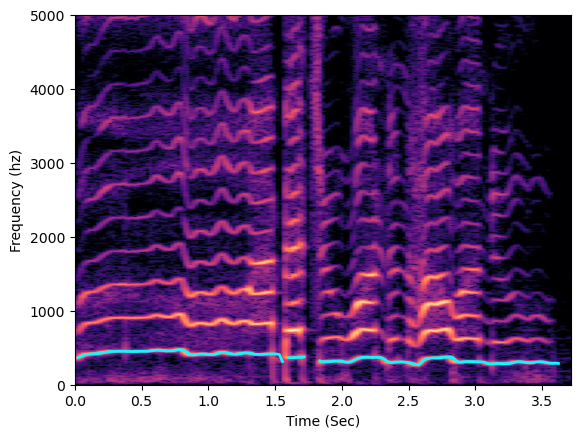

In [5]:
hop_length = 512
win_length = 2048
S = np.abs(librosa.stft(y, hop_length=hop_length, win_length=win_length))

maxfreqs, voiced_flag, voiced_probs = librosa.pyin(y, fmin=80, fmax=2000, sr=sr, hop_length=hop_length)
times = np.arange(len(maxfreqs))*hop_length/sr

plt.imshow(librosa.amplitude_to_db(S,ref=np.max), cmap='magma', extent=(times[0], times[-1], sr//2, 0), aspect='auto')
plt.ylim([0, 5000])
plt.plot(times, maxfreqs, linewidth=2, color='cyan')
plt.xlabel("Time (Sec)")
plt.ylabel("Frequency (hz)")


## Sonifying Instantaneous Frequency

In [9]:
def sonify_f0(maxfreqs, hop_length, sr):
    N = len(maxfreqs)
    df = np.zeros(N*hop_length) # Instantaneous frequency
    t = np.arange(hop_length)/sr
    ## TODO: Fill in df
    for i in range(len(maxfreqs)):
        if not np.isnan(maxfreqs[i]):
            df[i*hop_length:(i+1)*hop_length] = maxfreqs[i]
    
    # Integrate instantaneous frequency
    f = np.cumsum(df)/sr
    x = np.cos(2*np.pi*f)
    x = np.sign(x)*np.abs(x)**0.5
    return x

x = sonify_f0(maxfreqs, hop_length, sr)
ipd.Audio(x, rate=sr)

## Rounding Frequency To Nearest Note, Sonifying Again

### $f = 440 x 2^{p/12}$

### $ (f/440) = 2^{p/12}$

### $ \log_2(f/440) = p / 12$

### $ p = 12 \log_2(f/440) $


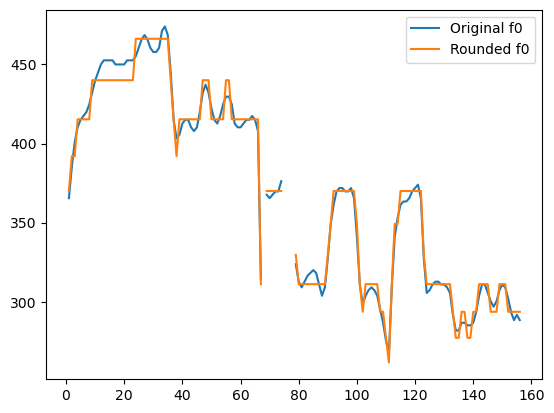

In [11]:
## TODO: Fill this in
p = 12*np.log2(maxfreqs/440)
p = np.round(p) # Round each note number to the nearest integer
maxfreqs_round = 440*(2**(p/12))

plt.plot(maxfreqs)
plt.plot(maxfreqs_round)
plt.legend(["Original f0", "Rounded f0"])

x = sonify_f0(maxfreqs_round, hop_length, sr)
ipd.Audio(x, rate=sr)

## Autotuning

In [13]:
from spectrogramtools import *

def do_autotune(S, maxfreqs, target):
    ratios = target/maxfreqs
    ratios[np.isnan(ratios)] = 1
    S2 = np.zeros_like(S)
    freqs = np.arange(S.shape[0])
    for j in range(S.shape[1]):
        new_freqs = freqs/ratios[j]
        sj = np.abs(S[:, j])
        S2[:, j] = np.interp(new_freqs, freqs, sj)
    return griffinLimInverse(S2, win_length, hop_length)

yshift = do_autotune(S, maxfreqs, maxfreqs_round)
ipd.Audio(yshift, rate=sr)

Iteration 1 of 10
Iteration 2 of 10
Iteration 3 of 10
Iteration 4 of 10
Iteration 5 of 10
Iteration 6 of 10
Iteration 7 of 10
Iteration 8 of 10
Iteration 9 of 10
Iteration 10 of 10


What if I insist that the target frequency is "concert A" (440hz) everywhere.

In [16]:
target = 440*np.ones(len(maxfreqs))
yshift = do_autotune(S, maxfreqs, target)
ipd.Audio(yshift, rate=sr)

Iteration 1 of 10
Iteration 2 of 10
Iteration 3 of 10
Iteration 4 of 10
Iteration 5 of 10
Iteration 6 of 10
Iteration 7 of 10
Iteration 8 of 10
Iteration 9 of 10
Iteration 10 of 10


Here is a 330hz "E3"

In [18]:
target = 330*np.ones(len(maxfreqs))
yshift = do_autotune(S, maxfreqs, target)
ipd.Audio(yshift, rate=sr)

Iteration 1 of 10
Iteration 2 of 10
Iteration 3 of 10
Iteration 4 of 10
Iteration 5 of 10
Iteration 6 of 10
Iteration 7 of 10
Iteration 8 of 10
Iteration 9 of 10
Iteration 10 of 10
